In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import re


# Feature Extraction Function

In [2]:
def extract_features(url):
    return {
        "url_length": len(url),
        "path_length": len(url.split("//")[-1].split("/", 1)[-1]) if "/" in url.split("//")[-1] else 0,
        "query_length": len(url.split("?")[-1]) if "?" in url else 0,
        "num_digits": sum(c.isdigit() for c in url),
        "num_letters": sum(c.isalpha() for c in url),
        "num_special": sum(not c.isalnum() for c in url),
        "count_dot": min(url.count('.'), 4),  # capped at 4
        "count_dash": url.count('-'),
        "count_slash": url.count('/'),
        "count_at": url.count('@'),
        "count_qmark": url.count('?'),
        "count_percent": url.count('%'),
        "count_equal": url.count('='),
        "has_https": int("https" in url.lower()),
        "has_ip": int(re.match(r"^https?:\/\/\d+\.\d+\.\d+\.\d+", url) is not None)
    }

# Load dataset

In [3]:
df = pd.read_csv("url_dataset_balanced.csv")
print("Dataset shape:", df.shape)
print("Label distribution:\n", df['label'].value_counts())

Dataset shape: (7087812, 3)
Label distribution:
 label
0.0    3543906
1.0    3543906
Name: count, dtype: int64


# Extract features

In [4]:
features = df['url'].apply(extract_features)
X = pd.DataFrame(features.tolist())
y = df['label']


# Train-test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# LightGBM Model

In [6]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 64,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=100)]
)


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.241443	valid_1's binary_logloss: 0.244131


# Evaluation

In [7]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, model.predict(X_test)))

Accuracy: 0.8932590650292086

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.88      0.89    708782
         1.0       0.88      0.91      0.90    708781

    accuracy                           0.89   1417563
   macro avg       0.89      0.89      0.89   1417563
weighted avg       0.89      0.89      0.89   1417563


Confusion Matrix:
 [[621312  87470]
 [ 63842 644939]]

ROC-AUC Score: 0.9615176208564647


# visualization

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# 1. Confusion Matrix

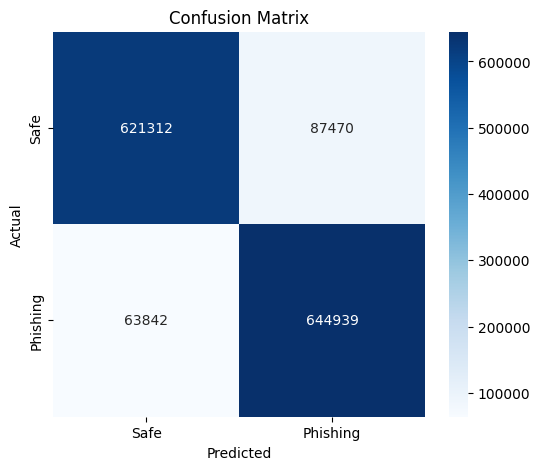

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Safe", "Phishing"], yticklabels=["Safe", "Phishing"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2. ROC Curve

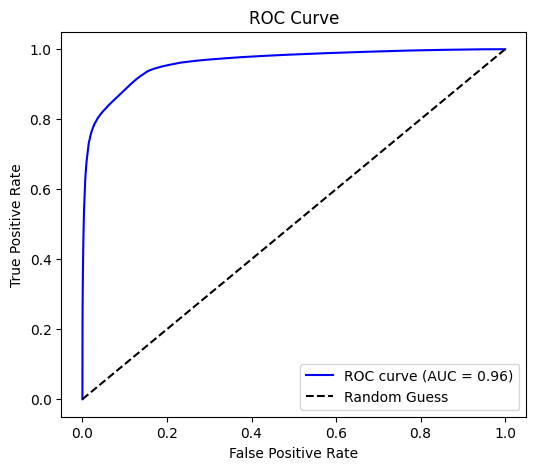

In [10]:
y_proba = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# 3. Feature Importance

/tmp/ipython-input-2683214802.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")


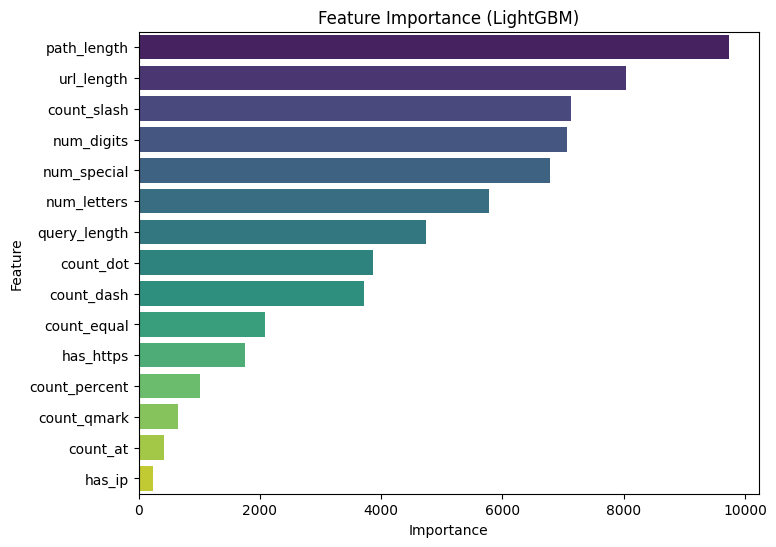

In [11]:
importance = model.feature_importance()
feature_names = X_train.columns
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importance}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis")
plt.title("Feature Importance (LightGBM)")
plt.show()

# Real-Time URL Prediction

In [39]:
# Single URL Prediction Function
# =========================================================
def predict_url(url, model):
    # Use the same feature extraction as training
    features = extract_features(url)
    X_new = pd.DataFrame([features])  # convert to dataframe

    # Predict probability
    prob = model.predict(X_new)[0]

    # Threshold = 0.5
    if prob > 0.5:
        return f"Phishing ❌ (Probability: {prob:.2f})"
    else:
        return f"Safe ✅ (Probability: {prob:.2f})"

# =========================================================
# Example usage
# =========================================================
print(predict_url("https://www.plugintoai.com", model))

Safe ✅ (Probability: 0.47)
